# Machine Learning Assignment Homework 1: Linear Models

## Introduction
In this notebook, I will create two regression based models to assess air quality.  
The target variable is the hourly averaged sensor response for CO.  
The notebook will cover the following steps:
- Data Processing
- Exploratory Data Analysis
- Linear Regression Implementation
- Logistic Regression Implementation
- Result Analysis - Linear Regression
- Result Analysis - Logistic Regression
- ROC Curve - Logistic Regression
- Inference - Linear and Logistic Regression

## (a) Data Processing

### Data Loading and Cleaning

In [1535]:
import os
import pandas as pd

# Current working directory
cwd = os.getcwd()

# Relative paths
data_train_path = os.path.join(cwd, '..', 'data', 'data_train.csv')
data_test_path = os.path.join(cwd, '..', 'data', 'data_test.csv')

# Load the training data
data_train = pd.read_csv(data_train_path)

# Load the test data
data_test = pd.read_csv(data_test_path)

I used the `pandas` library and the `read_csv` function to load the train and test datasets.

In [1536]:
# Display the first 5 rows
print(data_train.head())

# Print the shape of the training dataframe
print(f"\nShape of the training data: {data_train.shape}")

   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  

Shape of the training data: (6250, 13)


### Data Overview
The training data consists of the following features (the first column is *Unnamed: 0* which just contains the index starting from 0):
1. NMHC(GT): hourly averaged overall Non Metanic HydroCarbons concentration in microg/m3
2. C6H6(GT): hourly averaged Benzene concentration in microg/m3
3. PT08.S2(NMHC): hourly averaged sensor response to NMHC
4. NOx(GT): hourly averaged NOx concentration in ppb
5. PT08.S3(NOx): hourly averaged sensor response for NOx
6. NO2(GT): hourly averaged NO2 concentration in microg/m3
7. PT08.S4(NO2): hourly averaged sensor response for NO2
8. PT08.S5(O3): hourly averaged sensor response for O3
9. T: Temperature in C
10. RH: Relative Humidity
11. AH: Absolute Humidity
12. PT08.S1(CO): **TARGET VARIABLE** - hourly averaged sensor response for CO

The training data has 6250 rows and 13 columns.  
Each row of the data corresponds to a sample and columns denote the features.  
As we can see, the TARGET VARIABLE is the second column in our training data after the unnamed index column.

##### Data Cleaning

In [1537]:
# Check for missing values
missing_values = data_train.isnull().sum()
print("Number of missing values for each column in the training data:")
print(missing_values)
print(f"\nTotal number of missing values in the dataset: {missing_values.sum()}")

Number of missing values for each column in the training data:
Unnamed: 0        0
PT08.S1(CO)      77
NMHC(GT)         77
C6H6(GT)         77
PT08.S2(NMHC)    77
NOx(GT)          77
PT08.S3(NOx)     77
NO2(GT)          77
PT08.S4(NO2)     77
PT08.S5(O3)      77
T                77
RH               77
AH               77
dtype: int64

Total number of missing values in the dataset: 924


In [1538]:
# Drop rows with missing data in original dataframe using inplace=True
data_train.dropna(inplace=True)
print(f"Shape after dropping missing data: {data_train.shape}")

data_train.drop(columns=['Unnamed: 0'], inplace=True)

Shape after dropping missing data: (6173, 13)


##### Feature and Label Extraction

In [1539]:
# Extract the features and the label
X_train = data_train.drop(columns=['PT08.S1(CO)'], inplace=False)
y_train = data_train['PT08.S1(CO)']

print(f"Features: {X_train.columns.tolist()}")
print(f"Label: {y_train.name}")

Features: ['NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Label: PT08.S1(CO)


The features include all columns except the target variable `PT08.S1(CO)`.  
The target variable represents the hourly averaged sensor response for CO, which we aim to predict using regression models.

## (b) Exploratory Data Analysis

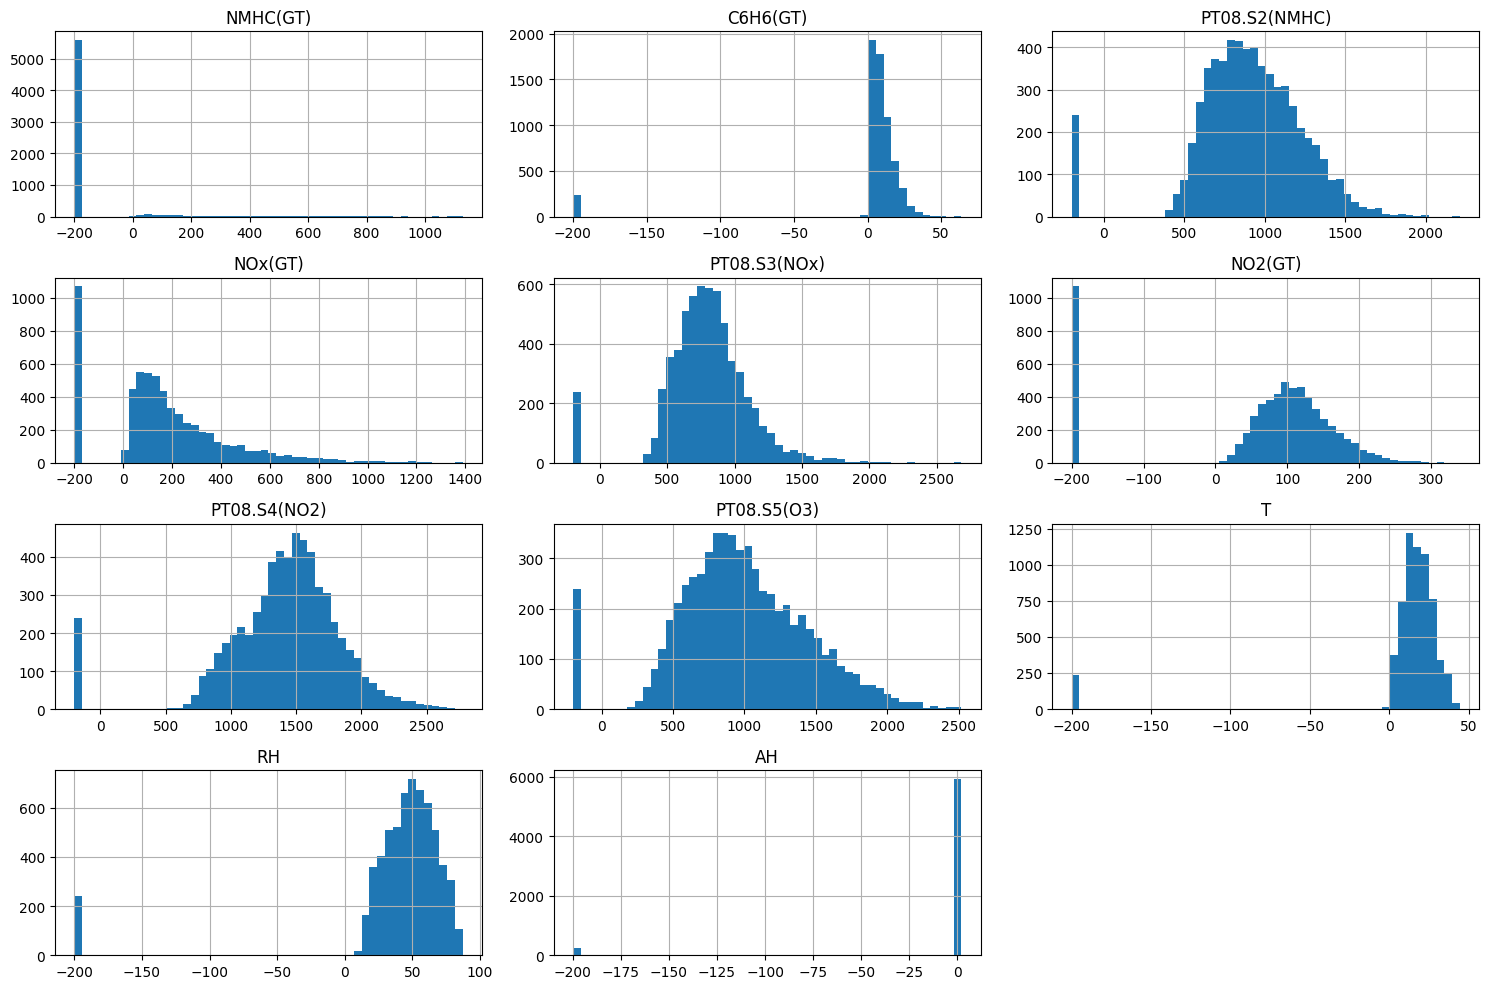

In [1540]:
import matplotlib.pyplot as plt

# Plot histograms
X_train.hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

##### Feature Distributions
As we can see, not all the features have a normal distribution (although some of them have quite normal distribution except that they have outliers as well).
- Skewed distributions: For instance, features like C6H6(GT), NOx(GT) appear right skewed
- Outliers: Almost all the features show significant outliers. The extreme negative values on the left seem unusual. For example, Absolute Humidity(AH) should not be negative, which suggests that these outliers could be erroneous data. Similarly, Benzene(C6H6) or other concentration in air cannot be negative.

Normalization or transformation of features seems necessary based on what the histograms reveal. The reasons for this include:
- Normalization: Scaling the data to a specific range seems to be a good idea to handle these features with different scales or units for our models. Features like T(Temperature) and RH(Relative Humidity) have values with drastically different ranges from others, which might impact our model. So bringing features to a common scale ensures that no single feature dominates others.
- Handling outliers: We can either replace the outlier values with mean/median values or remove those data points entirely since they appear to be erroneous.

In [1541]:
# Handling outliers: Replace the negative outlier values with the mean of positive values for each column
# for column in X_train.columns:
#   mean_value = X_train[column].mean()
#   X_train[column][X_train[column] < 0] = mean_value

# Apply Normalization
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std

##### Data Transformation
1. Outliers: The features have unreasonable negative values. I replaced these outliers with the mean of the positive values for each feature
2. Normalization: I applied standardization (Z-score normalization) to ensure all features have the same scale, making the mean of each feature 0 and the standard deviation 1. This ensures that no feature dominates the regression models due to it's scale.

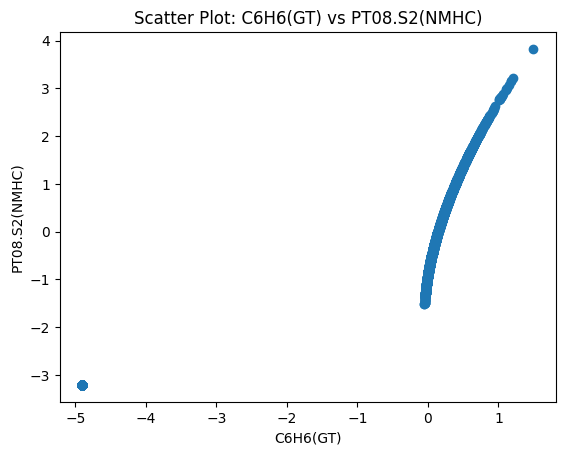

In [1542]:
# Select two features
feature_1 = 'C6H6(GT)'
feature_2 = 'PT08.S2(NMHC)'

# Create scatter plot
plt.scatter(X_train[feature_1], X_train[feature_2])
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.title(f'Scatter Plot: {feature_1} vs {feature_2}')
plt.show()

#### Scatter Plot Analysis
The scatter plot of `NO2(GT)` vs `NOx(GT)` shows a certain degree of correlation, indicating that as the concentration of NO2 increases, NOx concentration also tends to increase.

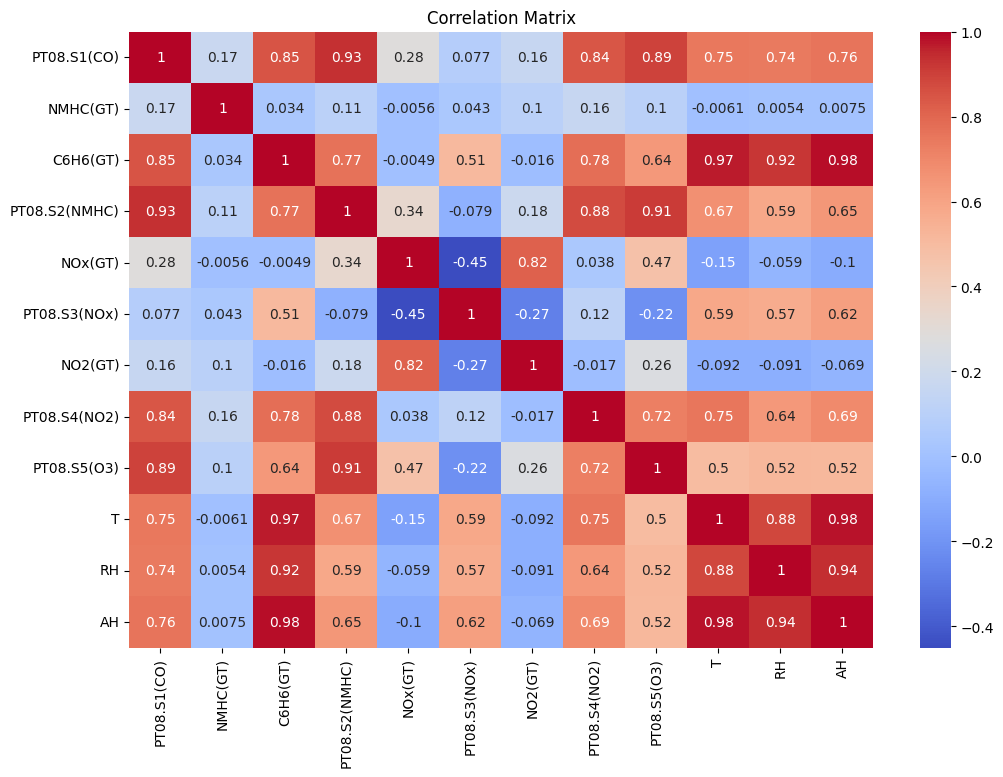

In [1543]:
import seaborn as sns

# Compute correlation matrix
C = data_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(C, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Correlation Heatmap Analysis

The heatmap above represents the Pearson correlation between all pairs of variables in the training data. The values range from -1 to 1, with positive values indicating a positive correlation and negative values indicating a negative correlation. The color intensity corresponds to the strength of the correlation. Cells with higher positive correlations will have colors closer to red, while negative correlations will be blue.

#### Key Observations:
1. **Strong Positive Correlation**:
    - **C6H6(GT)** and **PT08.S2(NMHC)**: There is a very high correlation (0.98) between these two features. This suggests that as the hourly averaged Benzene concentration increases, the hourly averaged sensor value for Non Metanic HydroCarbons also increases proportionally.
    - **C6H6(GT)** and **PT08.S5(O3)**: Another high correlation (0.87) exists between these features, indicating that ozone concentrations are also related to benzene levels.
    - **PT08.S2(NMHC)** and **PT08.S5(O3)**: These sensors are strongly correlated (0.88), which suggest that these sensors might be detecting similar environmental factors, indicating potential sensor redundancy.

2. **Moderate Positive Correlation**:
    - **NOx(GT)** shows a moderate positive correlation with **NO2(GT)** (0.77), indicating that as NOx increases, NO2 also tends to increase, which makes sense chemically as NOx compounds typically include NO2.
    - **C6H6(GT)** and **PT08.S4(NO2)**: A moderate positive correlation (0.77) exists between these two as well.
    - **PT08.S2(NMHC)** is moderately correlated with **PT08.S4(NO2)** (0.78), indicating that there is some relationship between the sensor values for NMHC and NO2, which could be related to common air pollution sources.
    - **Temperature (T)** and **Absolute Humidity (AH)**: These two variables show some positive correlation (0.64), suggesting that higher temperatures might coincide with higher absolute humidity levels.

3. **Low Correlation**:
    - Low positive and low negative correlation exists between multiple pair of features like 0.097 for **NMHC(GT)** and **NOx(GT)**, 0.19 for **C6H6(GT)** and **T**, -0.086 for **PT08.S2(NMHC)** and **RH**, -0.29 for **NO2(GT)** and **AH** alongwith many other such pairs.

4. **Negative Correlations**:
    - **PT08.S3(NOx)** has a strong negative correlation with **PT08.S2(NMHC)** (-0.80). This could suggest that higher levels of NOx are associated with lower levels of non-methane hydrocarbons, which may be due to differences in the sources or chemical reactivity of these pollutants.
    - **PT08.S3(NOx)** has a strong negative correlation with **PT08.S5(O3)** similarly suggesting increase in one sensor response is associated with a decrease in the other sensor response.
    - **C6H6(GT)** has a moderate negative correlation with **PT08.S3(NOx)** (-0.74).

We also notice that hourly averaged concentration of a chemical is not very strongly related with it's corresponding sensor response, which might indicate defective sensors or other chemicals affecting sensors.


In [1544]:
print('Number of negative values in each column:')
for column in X_train.columns:
  print(column, X_train[column][X_train[column] < 0].count())

X_train.drop(columns=['NMHC(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)'], inplace=True)

Number of negative values in each column:
NMHC(GT) 5581
C6H6(GT) 665
PT08.S2(NMHC) 3069
NOx(GT) 3514
PT08.S3(NOx) 3078
NO2(GT) 1697
PT08.S4(NO2) 2728
PT08.S5(O3) 3272
T 1309
RH 2049
AH 239


## (c) Linear Regression Implementation

In [1545]:
import numpy as np

# Linear Regression model implementation
class LinearRegression:
    def __init__(self):
        self.theta_best = None
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        X_b = np.c_[np.ones((n_samples, 1)), X]
        self.theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    def predict(self, X):
        n_samples = X.shape[0]
        X_b = np.c_[np.ones((n_samples, 1)), X]
        return X_b.dot(self.theta_best)

In [1546]:
def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

print(model.theta_best)

# Make predictions
y_pred = model.predict(X_train)

print(compute_rmse(y_train, y_pred))

[1053.13753442   45.64896064  104.80928212   49.74044805  107.48105247
 -126.06021585   23.9526294   150.13564209]
77.3361900221918


In [1547]:
# DELETE THIS CODE CELL (ONLY FOR TESTING PURPOSE)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_train)

# Print the weights (coefficients) for each feature
print(reg.coef_)

# Print the bias (intercept)
print(reg.intercept_)

[  45.64896064  104.80928212   49.74044805  107.48105247 -126.06021585
   23.9526294   150.13564209]
1053.137534424105


In [1548]:
# Logistic Regression model implementation
class LogisticRegression:
    def __init__(self, learning_rate=0.0001, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]

In [1549]:
# Binary label for logistic regression
y_train_binary = (y_train > 1000).astype(int)

# Train the model
logistic_model = LogisticRegression(learning_rate=0.01, n_iterations=1000)
logistic_model.fit(X_train.values, y_train_binary.values)

# Predict
logistic_predictions = logistic_model.predict(X_train.values)

print(compute_rmse(y_train_binary, logistic_predictions))

0.33746561164211225


In [1550]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train_binary)
y_pred = logreg.predict(X_train)

print(compute_rmse(y_train_binary, y_pred))

0.32797134524941973


In [1551]:
# DELETE THIS CELL (ONLY FOR TESTING PURPOSE)
cnt = 0
for i in range(len(y_pred)):
  if y_pred[i] != logistic_predictions[i]:
    cnt -= -1
print(cnt)

253
